<a href="https://colab.research.google.com/github/4LC4NT4R4/XMLD/blob/main/poo_xmld.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [29]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import csv
from scipy.interpolate import interp1d
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive



# Coleta de dados


In [30]:
class Spectrum():

    def __init__(self, x, y, pre=None, pos=None, E0=None, Ei=None, Ef=None, shift=None, name=None, legend=None):
        self.name = name
        self.legend = legend
        self.x = np.array(x)
        self.y = np.array(y)

        self.Ei=Ei #Cut the x,y data bellow Ei
        self.Ef=Ef #Cut the x,y data above Ef
        self.shift=shift #Energy shift

        if self.Ei is not None:
            mask_Ei = self.x >= self.Ei
            self.x=self.x[mask_Ei]
            self.y=self.y[mask_Ei]

        if self.Ef is not None:
            mask_Ef = self.x <= self.Ef
            self.x=self.x[mask_Ef]
            self.y=self.y[mask_Ef]

        if self.shift is not None:
            self.x+=self.shift/1000


        self.dy_dx = np.gradient(y, x) #Derivative of y with repect to x
        self.E0 = E0 #Energy theshhold

        # if E0 is not given, set E0 as the maximum of derivative
        if self.E0 is None:
            self.E0 = self.x[np.argmax(self.y)]

        # Verifica se pre e pos foram passados; se não, atribui valores padrão
        self.pre = pre if pre is not None else [-90, -40]
        self.pos = pos if pos is not None else [31, 142]

        # Normaliza usando o método norm
        self.norm_y = self.norm(self.x, self.y, self.E0, pre_edge=self.pre, pos_edge=self.pos)

    # Normalização de energia em eV
    def norm(self, x, y, e0, pre_edge=[-200, -50], pos_edge=[100, 300], n=1, m=1, flattering=True):
        X = np.array(x, dtype='float')
        Y = np.array(y, dtype='float')

        # Pré-borda (pre-edge)
        mask_pre = (X >= e0 + (pre_edge[0] / 1000)) & (X <= e0 + (pre_edge[1] / 1000))
        x_pre = X[mask_pre]
        y_pre = Y[mask_pre]

        # Ajuste polinomial para a pré-borda
        coefficients_pre = np.polyfit(x_pre, y_pre, n)
        p = np.poly1d(coefficients_pre)

        # Pós-borda (post-edge)
        mask_pos = (X >= e0 + (pos_edge[0] / 1000)) & (X <= e0 + (pos_edge[1] / 1000))
        x_pos = X[mask_pos]
        y_pos = Y[mask_pos]

        # Ajuste polinomial para a pós-borda
        coefficients_pos = np.polyfit(x_pos, y_pos, m)
        f = np.poly1d(coefficients_pos)

        # Cálculo do edge step
        edge_step = f(e0) - p(e0)

        # Normalização
        if flattering:
            Y = Y - p(X) * (1 - np.heaviside(X - e0, 1))
            Y = Y + (edge_step - f(X)) * np.heaviside(X - e0, 1)
            Y = Y / edge_step
        else:
            Y = Y - p(X)
            Y = Y / edge_step

        return Y


    def plot_normalized(self):
        fig, ax =plt.subplots()
        ax.plot(self.x, self.norm_y)
        plt.plot()





In [31]:
class Vortex:

    def __init__(self, path=None, s1=None, s2=None, s3=None, s4=None, roi=2, shift=None):
        """
        Inicializa a classe Vortex. Pode-se fornecer um caminho para um arquivo CSV (path)
        ou quatro espectros (s1, s2, s3, s4) diretamente.
        """
        self.path = path
        self.roi = roi
        self.shift=shift

        # Se os espectros não forem fornecidos, carrega do arquivo
        if path and not all([s1, s2, s3, s4]):
            self.data = self._data(self.path)  # Carregar dados do arquivo
            self.s1 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}1'] / self.data['I0'])
            self.s2 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}2'] / self.data['I0'])
            self.s3 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}3'] / self.data['I0'])
            self.s4 = Spectrum(self.data['Energy'], self.data[f'roi{self.roi}4'] / self.data['I0'])
        else:
            # Se os espectros forem fornecidos diretamente, apenas atribui
            self.s1 = s1
            self.s2 = s2
            self.s3 = s3
            self.s4 = s4


        # Verifica se os espectros foram corretamente inicializados
        if not all([self.s1, self.s2, self.s3, self.s4]):
            raise ValueError("Espectros insuficientes ou arquivo de dados não fornecido.")


        #Cria uma lista com os spectros
        self.spectra=[self.s1,self.s2,self.s3,self.s4]


        if self.shift is not None:
            for spectrum in self.spectra:
                spectrum.x+=self.shift/1000

        # Cria um espectro somado
        self.s = Spectrum(self.s1.x, self.s1.y + self.s2.y + self.s3.y + self.s4.y)


    def _data(self, path, line_skip=9):
        """
        Método para carregar dados de um arquivo CSV.
        path: caminho para o arquivo
        line_skip: número de linhas a serem ignoradas no início do arquivo
        """
        try:
            with open(path, 'r') as arquivo_csv:
                reader_csv = csv.reader(arquivo_csv)
                m = 0
                df = None

                for line in reader_csv:
                    line = line[0].split()
                    if line[0] == '#L':  # Header line
                        col = line[1:]  # Remove '#L' e usa o restante como colunas
                        df = pd.DataFrame(columns=col)  # Cria um DataFrame vazio com essas colunas

                    if m >= line_skip and df is not None:  # Começa a ler dados após `line_skip`
                        df.loc[m - line_skip] = [float(item) for item in line]
                    m += 1
            return df

        except Exception as e:
            print(f"Erro ao carregar dados: {e}")
            return None

    def plot_derivative(self):
        """
        Plota as derivadas dos espectros s1, s2, s3 e s4.
        """
        fig, axs = plt.subplots()
        axs.plot(self.s1.x, self.s1.dy_dx, marker='1', label='ROI1')
        axs.plot(self.s2.x, self.s2.dy_dx, marker='2', label='ROI2')
        axs.plot(self.s3.x, self.s3.dy_dx, marker='3', label='ROI3')
        axs.plot(self.s4.x, self.s4.dy_dx, marker='4', label='ROI4')
        axs.set_xlabel("Energy (eV)")
        axs.set_ylabel("dY/dX")
        axs.legend()
        plt.show()

    def plot_raw_data(self):
        """
        Plota os dados brutos (não normalizados) dos espectros s1, s2, s3 e s4.
        """
        fig, ax = plt.subplots(2, 2, sharex='col')

        ax[0, 0].plot(self.s1.x, self.s1.y, 'r-')
        ax[0, 0].set_title('Gráfico 1')

        ax[0, 1].plot(self.s2.x, self.s2.y, 'g-')
        ax[0, 1].set_title('Gráfico 2')

        ax[1, 0].plot(self.s3.x, self.s3.y, 'b-')
        ax[1, 0].set_title('Gráfico 3')

        ax[1, 1].plot(self.s4.x, self.s4.y, 'y-')
        ax[1, 1].set_title('Gráfico 4')

        plt.tight_layout()
        plt.show()

    def plot_normalized(self):
        """
        Plota os dados normalizados dos espectros s1, s2, s3 e s4.
        """
        fig, ax = plt.subplots(2, 2, sharex='col')

        ax[0, 0].plot(self.s1.x, self.s1.norm_y, 'r-')
        ax[0, 0].set_title('Gráfico 1')

        ax[0, 1].plot(self.s2.x, self.s2.norm_y, 'g-')
        ax[0, 1].set_title('Gráfico 2')

        ax[1, 0].plot(self.s3.x, self.s3.norm_y, 'b-')
        ax[1, 0].set_title('Gráfico 3')

        ax[1, 1].plot(self.s4.x, self.s4.norm_y, 'y-')
        ax[1, 1].set_title('Gráfico 4')

        plt.tight_layout()
        plt.show()


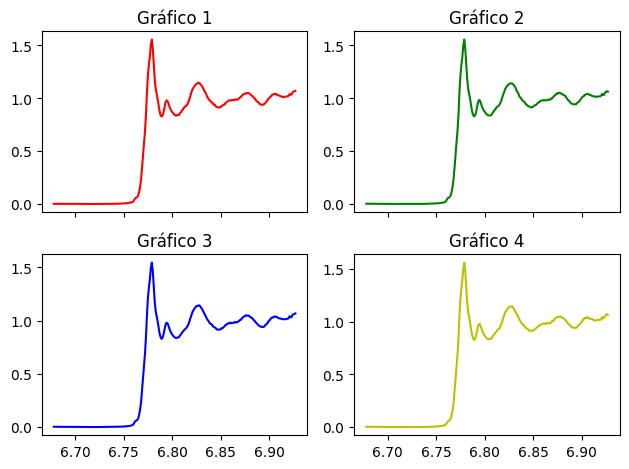

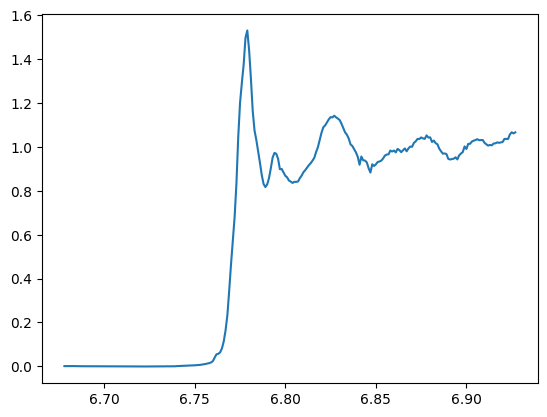

In [32]:
arq_1='B4_p40kp13_RT_1_A04062023_053631'
arq_2='B4_p40kp13_RT_3_A04062023_061749'
arq_3='B4_p40kp13_LT_1_A04062023_020113'
arq_4='B4_p40kp13_LT_3_A04062023_025315'

path='/content/drive/MyDrive/JupyterPrograms/XMLD/data/'
#Cada dado é importado utilizando a biblioteca pandas
#As tabelas são nomeadas como df (DataFrames)
df1=Vortex(path+arq_1+'.csv').data
#df1['Energy']=df1['Energy']+(1/1000)
#df1=df1[(df1['Energy'] >=7.729)]
#df1=df1[(df1['Energy'] <=7.915)]


df2=Vortex(path+arq_2+'.csv').data
#df2['Energy']=df2['Energy']+(1/1000)
#df2['Energy']=df2['Energy']+0.001
#df2=df2[(df2['Energy'] >=7.729)] #alinhamento
#df2=df2[(df2['Energy'] <=7.915)]

df3=Vortex(path+arq_3+'.csv').data
#df3['Energy']=df3['Energy']+(1/1000)
#df3=df3[(df3['Energy'] >=7.729)]
#df3=df3[(df3['Energy'] <=7.915)]

df4=Vortex(path+arq_4+'.csv').data
#df4['Energy']=df4['Energy']+(1/1000)
#df4['Energy']= df4['Energy']+0.001
#df4=df4[(df4['Energy'] >=7.729)]
#df4=df4[(df4['Energy'] <=7.915)]


c=Vortex(path+arq_1+'.csv', shift=-1000)
c.plot_normalized()

s=Spectrum(c.data['Energy'],c.data['roi21'], shift=-1000)
s.plot_normalized()


# Data visualization

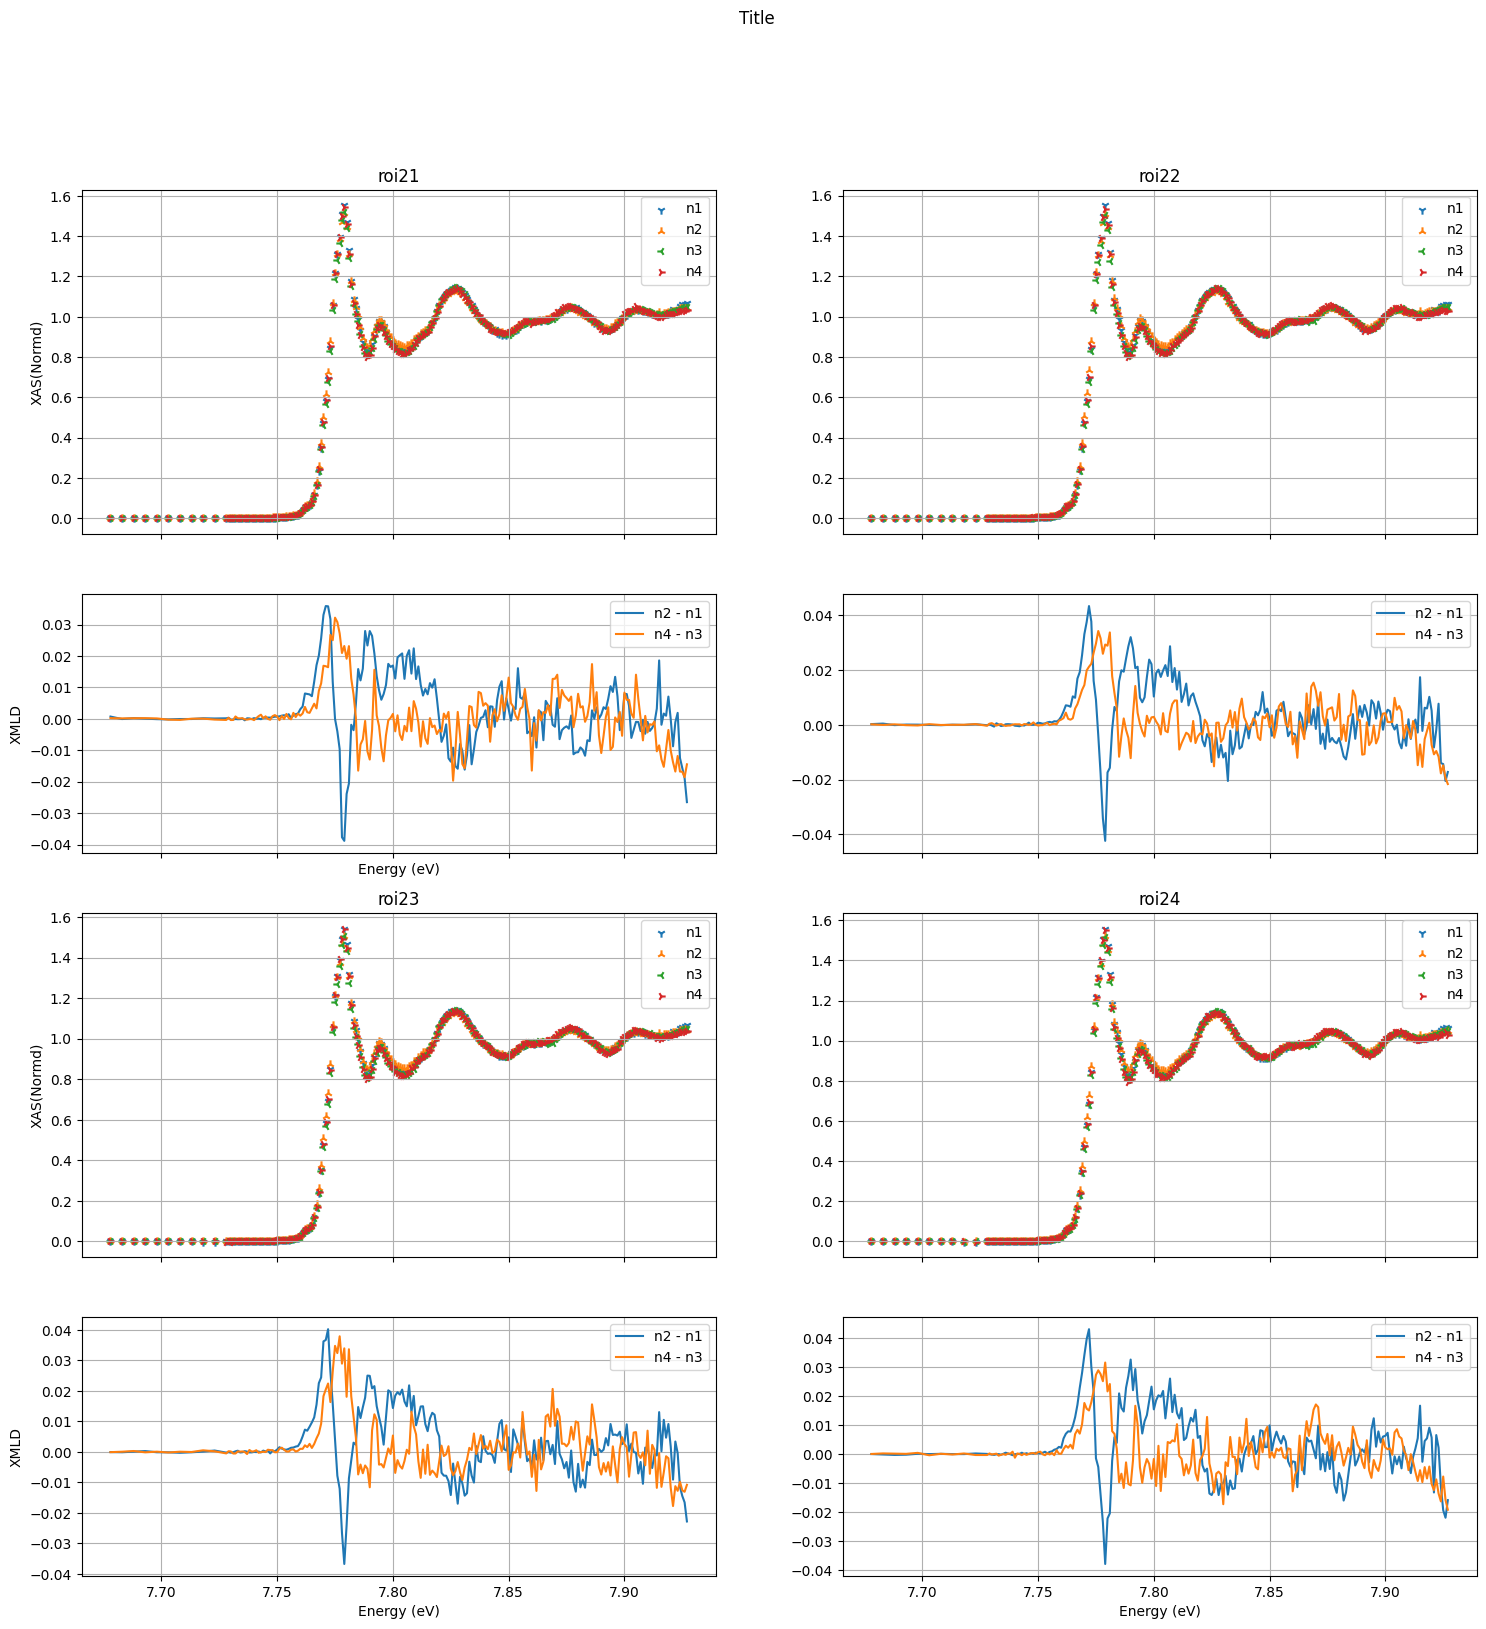

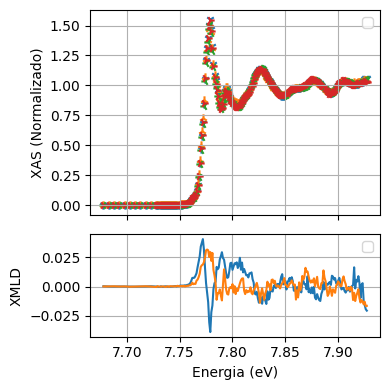

In [37]:
class xmld4:
    def __init__(self, arq1, arq2, arq3, arq4, title=None, shift=None):
        self.title = title
        self.shift=shift

        #Dados Brutos
        self.v1 = Vortex(arq1,shift=self.shift)
        self.v2 = Vortex(arq2,shift=self.shift)
        self.v3 = Vortex(arq3,shift=self.shift)
        self.v4 = Vortex(arq4,shift=self.shift)

        self.n1 = self.v1

        # Interpolação entre os dados
        self.n2 = Vortex(
            s1=Spectrum(self.n1.s1.x, np.interp(self.n1.s1.x, self.v2.s1.x, self.v2.s1.y)),
            s2=Spectrum(self.n1.s2.x, np.interp(self.n1.s2.x, self.v2.s2.x, self.v2.s2.y)),
            s3=Spectrum(self.n1.s3.x, np.interp(self.n1.s3.x, self.v2.s3.x, self.v2.s3.y)),
            s4=Spectrum(self.n1.s4.x, np.interp(self.n1.s4.x, self.v2.s4.x, self.v2.s4.y))
        )

        self.n3 = Vortex(
            s1=Spectrum(self.n1.s1.x, np.interp(self.n1.s1.x, self.v3.s1.x, self.v3.s1.y)),
            s2=Spectrum(self.n1.s2.x, np.interp(self.n1.s2.x, self.v3.s2.x, self.v3.s2.y)),
            s3=Spectrum(self.n1.s3.x, np.interp(self.n1.s3.x, self.v3.s3.x, self.v3.s3.y)),
            s4=Spectrum(self.n1.s4.x, np.interp(self.n1.s4.x, self.v3.s4.x, self.v3.s4.y))
        )

        self.n4 = Vortex(
            s1=Spectrum(self.n1.s1.x, np.interp(self.n1.s1.x, self.v4.s1.x, self.v4.s1.y)),
            s2=Spectrum(self.n1.s2.x, np.interp(self.n1.s2.x, self.v4.s2.x, self.v4.s2.y)),
            s3=Spectrum(self.n1.s3.x, np.interp(self.n1.s3.x, self.v4.s3.x, self.v4.s3.y)),
            s4=Spectrum(self.n1.s4.x, np.interp(self.n1.s4.x, self.v4.s4.x, self.v4.s4.y))
        )

    def plot_rois(self):
        # Cria a figura e os subplots
        fig, axs = plt.subplots(4, 2, figsize=(18, 18), gridspec_kw={'height_ratios': [4, 3, 4, 3]}, sharex=True)
        fig.suptitle(self.title or 'Title')

        l = 0
        m = 0

        for i, ax in enumerate(axs.flatten()):

            if i == 0 or i == 1 or i == 4 or i == 5:
                if i == 0 or i == 4:
                    ax.set_ylabel('XAS(Normd)')
                ax.set_title(f'roi2{l+1}')

                # Definir os dados de espectro para o subplot
                x1, y1 = self.n1.spectra[l].x, self.n1.spectra[l].norm_y
                x2, y2 = self.n2.spectra[l].x, self.n2.spectra[l].norm_y
                x3, y3 = self.n3.spectra[l].x, self.n3.spectra[l].norm_y
                x4, y4 = self.n4.spectra[l].x, self.n4.spectra[l].norm_y

                # Plotar os dados
                ax.scatter(x1, y1, marker='1', label='n1')
                ax.scatter(x2, y2, marker='2', label='n2')
                ax.scatter(x3, y3, marker='3', label='n3')
                ax.scatter(x4, y4, marker='4', label='n4')

                ax.grid()
                ax.legend()
                l += 1

            elif i == 2 or i == 3 or i == 6 or i == 7:

                # Diferença entre os espectros
                diff1 = self.n2.spectra[m].norm_y - self.n1.spectra[m].norm_y
                diff2 = self.n4.spectra[m].norm_y - self.n3.spectra[m].norm_y

                ax.plot(self.n1.spectra[m].x, diff1, label='n2 - n1')
                ax.plot(self.n3.spectra[m].x, diff2, label='n4 - n3')

                if i == 6 or i == 7 or i == 2:
                    ax.set_xlabel('Energy (eV)')
                if i == 2 or i == 6:
                    ax.set_ylabel('XMLD')

                ax.grid()
                ax.legend()
                m += 1

    def plot(self):
        # Crie a figura e os eixos com ajuste de espaçamento vertical e proporções de altura
        fig, (ax1, ax2) = plt.subplots(nrows=2, figsize=(4, 4), sharex=True, gridspec_kw={'height_ratios': [2, 1]})
        #plt.subplots_adjust(hspace=0)

        # Plote o primeiro gráfico
        ax1.scatter(self.n1.s.x, self.n1.s.norm_y,  marker='1')
        ax1.scatter(self.n2.s.x, self.n2.s.norm_y,  marker='2')
        ax1.scatter(self.n3.s.x, self.n3.s.norm_y,  marker='3')
        ax1.scatter(self.n4.s.x, self.n4.s.norm_y,  marker='4')
        ax1.grid()
        ax1.legend()
        ax1.set_ylabel('XAS (Normalizado)')


        # Plote o segundo gráfico no mesmo eixo
        ax2.plot(self.n1.s.x,self.n2.s.norm_y-self.n1.s.norm_y)
        ax2.plot(self.n3.s.x,self.n4.s.norm_y-self.n3.s.norm_y)
        ax2.legend()
        ax2.grid()
        ax2.set_xlabel('Energia (eV)')
        ax2.set_ylabel('XMLD')


        # Exiba o gráfico
        plt.tight_layout()

        plt.show()




# Exemplo de uso
arq1 = 'B4_p40kp13_RT_1_A04062023_053631'
arq2 = 'B4_p40kp13_RT_3_A04062023_061749'
arq3 = 'B4_p40kp13_LT_1_A04062023_020113'
arq4 = 'B4_p40kp13_LT_3_A04062023_025315'

path = '/content/drive/MyDrive/JupyterPrograms/XMLD/data/'

# Instanciando e plotando
a = xmld4(path + arq1 + '.csv', path + arq2 + '.csv', path + arq3 + '.csv', path + arq4 + '.csv')
a.plot_rois()
a.plot()
